In [2]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level
import math

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact_manual

plotting_backend = "plotly-static"

In [11]:
df=pd.read_csv("cleaned_ECG.csv")
df.shape

(7680, 3)

In [12]:
df.head()

,Timestamp,ECG1,ECG2
0,2024-01-01 00:00:00.000,0.16,-0.29
1,2024-01-01 00:00:00.008,0.18,-0.30
2,2024-01-01 00:00:00.016,0.17,-0.32
3,2024-01-01 00:00:00.023,0.18,-0.29
4,2024-01-01 00:00:00.031,0.18,-0.31


In [ ]:
df.drop(columns=['ECG2'],inplace=True) #considering only one ECG signal for forecasting
df.columns = ['ds', 'y']

In [14]:
df

,ds,y
0,2024-01-01 00:00:00.000,0.16
1,2024-01-01 00:00:00.008,0.18
2,2024-01-01 00:00:00.016,0.17
3,2024-01-01 00:00:00.023,0.18
4,2024-01-01 00:00:00.031,0.18
...,...,...
7675,2024-01-01 00:00:59.961,-0.10
7676,2024-01-01 00:00:59.969,-0.11
7677,2024-01-01 00:00:59.977,-0.12
7678,2024-01-01 00:00:59.984,-0.11


In [15]:
fig = px.line(df, x=df["ds"], y=df["y"])
fig.show()

## Neural Prophet

In [22]:
quantiles = [0.015, 0.985]

params = {
    "n_lags": 24,
    "n_forecasts": 7,
    "n_changepoints": 20,
    "learning_rate": 0.01,
    "ar_layers": [32, 16, 16, 32],
    "epochs": 70,
    "batch_size": 64,
    "quantiles": quantiles,
}


m = NeuralProphet(**params)
m.set_plotting_backend(plotting_backend)
set_log_level("ERROR")

In [23]:
df_train, df_test = m.split_df(df, valid_p=0.1, local_split=True)
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (6910, 2)
Test shape: (794, 2)


In [24]:
metrics_fit = m.fit(df_train, freq="D", metrics=True)

Training: 0it [00:00, ?it/s]

In [25]:
forecast = m.predict(df_test)

Predicting: 108it [00:00, ?it/s]

In [26]:
fig = go.Figure()
fig.update_layout(title="Neural Prophet with GOOG")
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real Data'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat1'], mode='lines', name='Forecast Data'))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Training'))
fig.show()

In [28]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(f'R2 Score : {r2_score(forecast.iloc[25:]["y"],forecast.iloc[25:]["yhat1"])}')
print(f'RMSE : {math.sqrt(mean_squared_error(forecast.iloc[25:]["y"],forecast.iloc[25:]["yhat1"]))}')
print(f'MAE : {mean_absolute_error(forecast.iloc[25:]["y"],forecast.iloc[25:]["yhat1"])}')

R2 Score : 0.9670493752780976
RMSE : 0.054343972013596795
MAE : 0.03519906022923821


## LSTM 

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [36]:
from keras.preprocessing.sequence import TimeseriesGenerator
 
n_input = 24
n_features = 1
generator = TimeseriesGenerator(df_train['y'],
                                df_train['y'],
                                length=n_input,
                                batch_size=32)
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[ 0.16  0.18  0.17  0.18  0.18  0.17  0.17  0.13  0.13  0.1   0.06  0.04
  0.01 -0.01 -0.02 -0.02 -0.02 -0.03  0.    0.    0.    0.02  0.03  0.04
  0.18  0.17  0.18  0.18  0.17  0.17  0.13  0.13  0.1   0.06  0.04  0.01
 -0.01 -0.02 -0.02 -0.02 -0.03  0.    0.    0.    0.02  0.03  0.04  0.03
  0.17  0.18  0.18  0.17  0.17  0.13  0.13  0.1   0.06  0.04  0.01 -0.01
 -0.02 -0.02 -0.02 -0.03  0.    0.    0.    0.02  0.03  0.04  0.03  0.07
  0.18  0.18  0.17  0.17  0.13  0.13  0.1   0.06  0.04  0.01 -0.01 -0.02
 -0.02 -0.02 -0.03  0.    0.    0.    0.02  0.03  0.04  0.03  0.07  0.05
  0.18  0.17  0.17  0.13  0.13  0.1   0.06  0.04  0.01 -0.01 -0.02 -0.02
 -0.02 -0.03  0.    0.    0.    0.02  0.03  0.04  0.03  0.07  0.05  0.06
  0.17  0.17  0.13  0.13  0.1   0.06  0.04  0.01 -0.01 -0.02 -0.02 -0.02
 -0.03  0.    0.    0.    0.02  0.03  0.04  0.03  0.07  0.05  0.06  0.05
  0.17  0.13  0.13  0.1   0.06  0.04  0.01 -0.01 -0.02 -0.02 -0.02 -0.03
  0.    0.    0.    0.02  0.03  0

In [37]:
# define model
model = Sequential()
model.add(LSTM(75, activation='relu',
               input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()
history = model.fit(generator, epochs=60)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 75)                23100     
                                                                 
 dense_1 (Dense)             (None, 1)                 76        
                                                                 
Total params: 23176 (90.53 KB)
Trainable params: 23176 (90.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/60
216/216 [==============================] - 5s 13ms/step - loss: 0.1015
Epoch 2/60
216/216 [==============================] - 3s 12ms/step - loss: 0.3271
Epoch 3/60
216/216 [==============================] - 3s 14ms/step - loss: 0.0727
Epoch 4/60
216/216 [==============================] - 3s 15ms/step - loss: 0.0654
Epoch 5/60
216/216 [==============================] - 3s 13ms/step - loss: 0.0629
Epoc

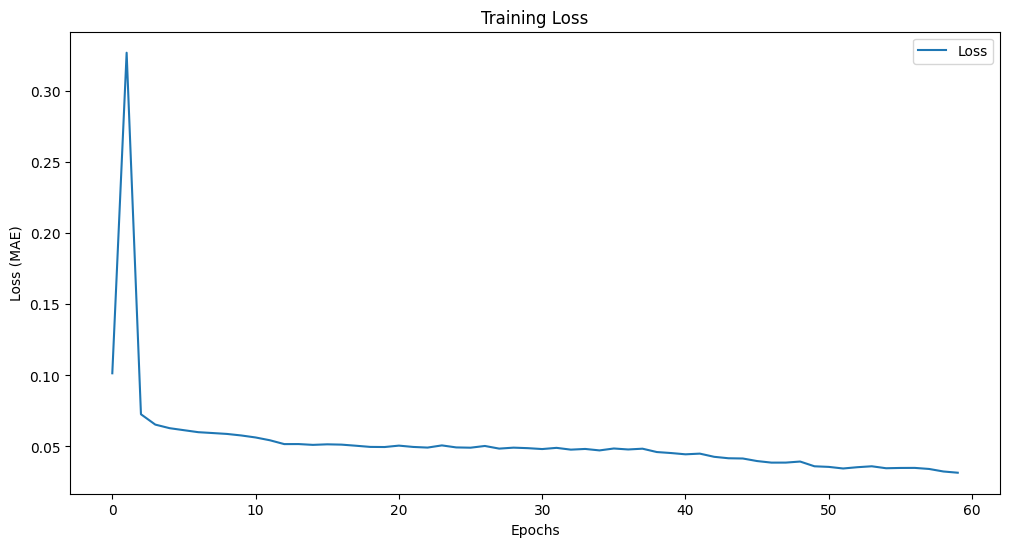

In [38]:
import matplotlib.pyplot as plt
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [40]:
n_input = 24
n_features = 1
test_generator = TimeseriesGenerator(df['y'],
                                df['y'],
                                length=n_input,
                                batch_size=32)
out=model.predict(test_generator)

240/240 [==============================] - 2s 5ms/step


In [41]:
out_test=out[df.shape[0]-df_test.shape[0]-n_input:]
out_test.reshape(-1).shape

(794,)

In [42]:
fig = go.Figure()
fig.update_layout(title="LSTM with GOOG")
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real Data'))
fig.add_trace(go.Scatter(x=df_test['ds'], y=out_test.reshape(-1), mode='lines', name='Forecast Data'))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Training'))
fig.show()

In [44]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(f'R2 Score : {r2_score(df_test.y,out[df.shape[0]-df_test.shape[0]-n_input:])}')
print(f'RMSE : {math.sqrt(mean_squared_error(df_test.y,out[df.shape[0]-df_test.shape[0]-n_input:]))}')
print(f'MAE : {mean_absolute_error(df_test.y,out[df.shape[0]-df_test.shape[0]-n_input:])}')

R2 Score : 0.9578841993266044
RMSE : 0.06220095428269276
MAE : 0.024464334775822744


## ARIMA

In [45]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [48]:
from numba import jit,cuda

In [64]:
def grid_search_arima(data, p_range, d_range, q_range):
    best_score = float('inf')
    best_order = None
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(data, order=(p,d,q))
                    results = model.fit()
                    aic = results.aic
                    if aic < best_score:
                        best_score = aic
                        best_order = (p,d,q)
                except:
                    continue
    return best_order

def rolling_arima_predictions(train_data, test_data, order):
    predictions = []
    history = list(train_data)
    for t in range(len(test_data)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)[0]
        predictions.append(pred)
        history.append(test_data[t])
    return np.array(predictions)

In [65]:
best_order = grid_search_arima(df_train['y'], 
                             p_range=range(0,3), 
                             d_range=range(0,2), 
                             q_range=range(0,3))
print(f"Best ARIMA order: {best_order}")

Best ARIMA order: (2, 0, 1)


In [66]:
arima_preds = rolling_arima_predictions(df_train['y'].values, df_test['y'].values, best_order)

In [67]:
fig = go.Figure()
fig.update_layout(title="Rolling ARIMA with GOOG")
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real Data'))
fig.add_trace(go.Scatter(x=df_test['ds'], y=arima_preds.reshape(-1), mode='lines', name='Forecast Data'))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Training'))
fig.show()

In [68]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(f'R2 Score : {r2_score(df_test.y,arima_preds)}')
print(f'RMSE : {math.sqrt(mean_squared_error(df_test.y,arima_preds))}')
print(f'MAE : {mean_absolute_error(df_test.y,arima_preds)}')

R2 Score : 0.6155627419827622
RMSE : 0.18792616549544103
MAE : 0.05895606161396315
